# ChainerによるDeep Learning実装（基礎）

In [2]:
import chainer

In [3]:
chainer.print_runtime_info()

Platform: Linux-4.19.121-linuxkit-x86_64-with-glibc2.28
Chainer: 7.8.1
ChainerX: Not Available
NumPy: 1.22.2
CuPy: Not Available
iDeep: Not Available


# Step1　データ準備

In [9]:
from sklearn.datasets import load_iris

# Iris データセットの読み込み
x, t = load_iris(return_X_y=True)

print('x:', x.shape)
print('t:', t.shape)

x: (150, 4)
t: (150,)


In [5]:
# それぞれデータ型をChainer用に変換
x = x.astype('float32')
t = t.astype('int32')

In [8]:
# データセットの分割
from sklearn.model_selection import train_test_split

# 訓練データ・検証データ・テストデータに分割
x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)

# Step2 ニューラルネットワークの設定

In [10]:
import chainer.links as L
import chainer.functions as F

In [12]:
# 全結合層のReLU関数
l = L.Linear(3,2)

from chainer import Sequential
# netとしてインスタンス化
# 元データの入力データが4層・2つ目は10層の全結合層を準備
# 結果は3種類の分類
n_input = 4
n_hidden = 10
n_output = 3

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

# Step3 目的関数の設定

目的関数：交差エントロピー　※分類問題の一般的な目的関数を使用

# Step4　最適化手法を設定

今回は確率的勾配降下法を使用

In [13]:
optimizer = chainer.optimizers.SGD(lr=0.01)

In [14]:
# netを最適化手法に合わせて更新する
optimizer.setup(net)

# Step5　ニューラルネットワークの訓練

In [15]:
# 訓練用のエポック数とバッチサイズ
n_epoch = 30
n_batchsize = 16

In [28]:
# 訓練の実装
import numpy as np

iteration = 0

# ログの保存用
results_train = {
    'loss':[],
    'accuracy':[]
}
results_valid = {
    'loss':[],
    'accuracy':[]
}


for epoch in range(n_epoch):
    
    #　データセット並び替えた順番を取得
    order = np.random.permutation(range(len(x_train)))
    
    # 各バッチの目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []
    
    for i in range(0, len(order), n_batchsize):
        # バッチ準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]
        
        # 予測値の出力
        y_train_batch = net(x_train_batch)
        
        # 目的関数を適応して、分類精度の計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)
        
        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)
        
        # 勾配リセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()
        
        # パラメータの更新
        optimizer.update()
        
        # カウントアップ
        iteration += 1
    
    # 訓練データに対する目的関数の出力と分類精度の集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)
    
    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)
        
    # 目的関数を適応して、分類精度の計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)
    
    # 結果出力
    print(f"epoch:{epoch} iteration:{iteration} loss(train):{loss_train:.4f} loss(valid):{loss_val.array:.4f}")
    
    # ログの保存
    results_train['loss'].append(loss_train)
    results_train['accuracy'].append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch:0 iteration:5 loss(train):0.2565 loss(valid):0.1953
epoch:1 iteration:10 loss(train):0.2620 loss(valid):0.1933
epoch:2 iteration:15 loss(train):0.2629 loss(valid):0.1901
epoch:3 iteration:20 loss(train):0.2602 loss(valid):0.2064
epoch:4 iteration:25 loss(train):0.2537 loss(valid):0.1887
epoch:5 iteration:30 loss(train):0.2472 loss(valid):0.1880
epoch:6 iteration:35 loss(train):0.2445 loss(valid):0.1946
epoch:7 iteration:40 loss(train):0.2496 loss(valid):0.1796
epoch:8 iteration:45 loss(train):0.2374 loss(valid):0.1775
epoch:9 iteration:50 loss(train):0.2572 loss(valid):0.1755
epoch:10 iteration:55 loss(train):0.2388 loss(valid):0.1750
epoch:11 iteration:60 loss(train):0.2406 loss(valid):0.1715
epoch:12 iteration:65 loss(train):0.2207 loss(valid):0.1704
epoch:13 iteration:70 loss(train):0.2191 loss(valid):0.1680
epoch:14 iteration:75 loss(train):0.2262 loss(valid):0.1704
epoch:15 iteration:80 loss(train):0.2372 loss(valid):0.1639
epoch:16 iteration:85 loss(train):0.2330 loss(valid

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

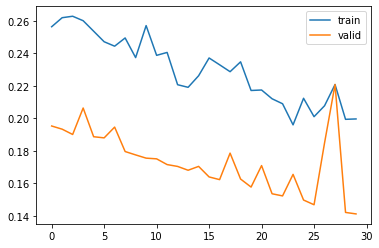

In [30]:
# 目的関数の出力（loss）

plt.plot(results_train['loss'], label='train')
plt.plot(results_valid['loss'], label='valid')
plt.legend()

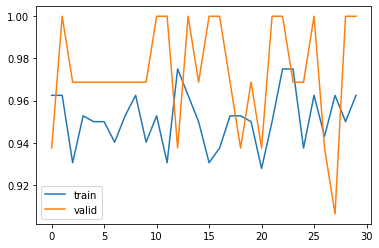

In [31]:
# 分類制度（acuuracy)
plt.plot(results_train['accuracy'], label='train')
plt.plot(results_valid['accuracy'], label='valid')
plt.legend()

In [33]:
# テストデータで予測値を計算
with chainer.using_config("train", False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)

In [35]:
accuracy_test = F.accuracy(y_test, t_test)
accuracy_test.array

array(0.95555556, dtype=float32)

In [37]:
# ニューラルネットワークの保存
chainer.serializers.save_npz('my_iris.net', net)

In [39]:
#　訓練済みニューラルネットワークを用いた推論
loaded_net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [40]:
chainer.serializers.load_npz('my_iris.net', loaded_net)

In [41]:
with chainer.using_config("train", False), chainer.using_config("enable_backprop", False):
    y_test = loaded_net(x_test)

In [42]:
accuracy_test = F.accuracy(y_test, t_test)
accuracy_test.array

array(0.95555556, dtype=float32)